In [1]:
# Generic imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import scipy.optimize as optimization
sys.path.append('../../..')
import plotly.graph_objects as go
from plotly.offline import iplot

# Local imports
import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

CUDA not available.


In [2]:
%matplotlib inline

The next cell has parameters that might change from crystal to crystal

In [3]:
# Loading in the compressed data
Segmentname = 'Segments3'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation
accumlist = [0,1,2] # Segment indexing starts at 0 for the upper-left, down, then across

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .07
Z2offset = 0.0001
nbins_max = 5
levels = 3

Segments3_compr_flat_filt.npz


In [4]:
# # Loading in the compressed data
# Segmentname = 'Segments1'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [12,13,14,15,16,17,18,19] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .011
# Z2offset = 0.0001
# nbins_max = 8
# levels = 3

In [5]:
# # Loading in the compressed data
# Segmentname = 'Segments2'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .25
# Z2offset = 0.001
# nbins_max = 8
# levels = 3

In [6]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename); print(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments3_compr_flat_filt_roughness.jpg
Segments3_compr_flat_filt.npz
1
2023-06-21/case3.1 (calibration2)


In [7]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
print('Using levels =', levels, 'for uncertainty analysis')

Accumulating segments [0, 1, 2]
Plotting segments [0, 1, 2]
Z2 ranging from 0.0 to 0.07
Max number of bins specified is 5
Sturges rule says maxbins = 12
Using nbins =  5
Using levels = 3 for uncertainty analysis


Original =  2750
4 0 688 [582  89  14   2]
4 1 688 [581  86  16   4]
4 2 687 [594  78  12   2]
4 3 687 [580  90  15   2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0091523427151249
statsigma =  0.09566787713294833

****Working on segment 0
std dev of height =  0.5460087229523146
integral =  0.010024117218784129
[83.74107777 11.57373075  1.8093052   0.2452286 ]


polyfit solution [-103.75310802    4.40338861]
Based on bins: sigmaG =  0.09817466824411938


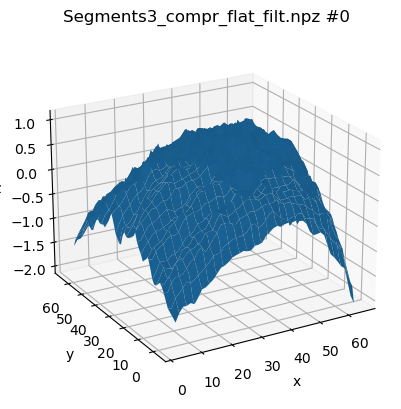

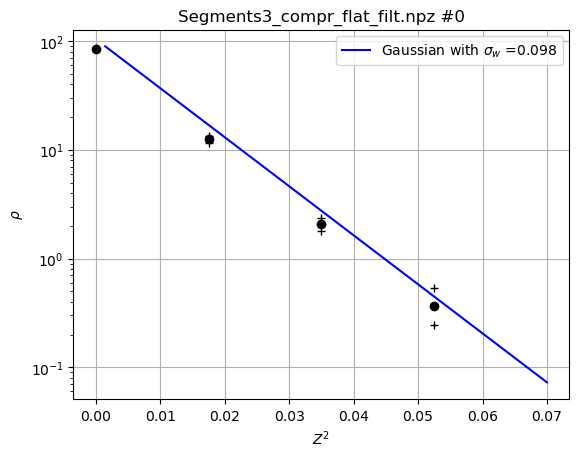

In [8]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# This suppresses warnings when lots of graphics windows are open
import matplotlib
matplotlib.rc('figure', max_open_warning = 0)

# This is for when we want to show or suppress intermediate graphics and other output
Show_intermediate_graphics = True

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        if Show_intermediate_graphics:
            fig1 = plt.figure()
            ax = fig1.add_subplot(111, projection='3d')
            ax.plot_surface(xgrid, ygrid, sollast)
            title = Flattenedfilename+' #'+str(isegment)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.set_title(title)
            ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # This is for calculating the errors in fitting (and graphing)
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)

        # Graph the probability
        if Show_intermediate_graphics:
            
            # Using matplotlib
            plt.figure()
            plt.semilogy(bins, counts, 'ok')
            plt.semilogy(bins, countsplus, '+k')
            plt.semilogy(bins, countsminus,'+k')
            plt.title(title)
            plt.xlabel(r'$Z^{2}$')
            plt.ylabel(r'$\rho$')
            plt.grid(True)
            
            # Using plotly
            plot1 = go.Scatter(x=bins, y=np.log(counts), marker=dict(color='blue'),mode='markers')
            plot2 = go.Scatter(x=bins, y=np.log(countsplus), marker=dict(color='black'),mode='markers')
            plot3 = go.Scatter(x=bins, y=np.log(countsminus), marker=dict(color='black'),mode='markers')
            iplot([plot1,plot2,plot3])

        # Eliminate entries greater than a threshold (not sure if this is necessary)
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])

#         # Attempt a best-fit based on the raw data
#         analysis = Fit_Weibull_2P(failures=Z2flat_new,show_probability_plot=False)
#         etaW = analysis.beta; #print('analysis.beta=',analysis.beta)
#         sigma2W = analysis.alpha; #print('analysis.alpha=',analysis.alpha)
#         sigmaW = np.sqrt(sigma2W)
#         print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)
        
#         # Attempt a best-fit based on the bins
#         errors = np.log(countsplus/counts); #print(errors)
#         solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
#         etaW = solution[1]
#         sigma2W = solution[0]
#         sigmaW = np.sqrt(sigma2W)
#         print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

        # Best-fit based on linear fit to the bins
        errors = np.log(countsplus/counts); #print(errors)
        solution = np.polyfit(bins+Z2offset, np.log(counts), 1)
        print('polyfit solution', solution)
        sigma2G = -1/solution[0]
        sigmaG = np.sqrt(sigma2G)
        print('Based on bins: sigmaG = ', sigmaG)
        
#         # Graph the best-fit probability
#         myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
#         if Show_intermediate_graphics:
#             plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
#             plt.legend()

        # Graph the best-fit probability
        myGaussian = sts.Gaussian(Z2theory,sigma2G)
        if Show_intermediate_graphics:
            plt.semilogy(Z2theory, myGaussian, 'b',label = 'Gaussian with $\sigma_w$ =' + str(sigmaG)[0:5])
            plt.legend()

    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

In [9]:
sts.logWeibull

<function statstuff.logWeibull(Z2, sigma2W, etaW)>

In [10]:
# Sum up the accumulated information
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
Z2flat_new = np.squeeze(Z2flat_total)

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

# Attempt a best-fit based on the raw data
# plt.figure()
# analysis = Fit_Weibull_2P(failures=Z2flat_new)
# etaW = analysis.beta; print('analysis.beta=',analysis.beta)
# sigma2W = analysis.alpha; print('analysis.alpha=',analysis.alpha)
# sigmaW = np.sqrt(sigma2W)
# print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)

Original =  2750
4 0 688 [582  89  14   2]
4 1 688 [581  86  16   4]
4 2 687 [594  78  12   2]
4 3 687 [580  90  15   2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0091523427151249
statsigma =  0.09566787713294833
integral =  0.010024117218784129


In [11]:
# Attempt a best-fit based on the bins
errors = np.log(countsplus/counts); #print(errors)
solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
etaW = solution[1]
sigma2W = solution[0]
sigmaW = np.sqrt(sigma2W)
print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

Based on bins: sigmaW, etaW =  0.3023259570145756 0.6293030655964941


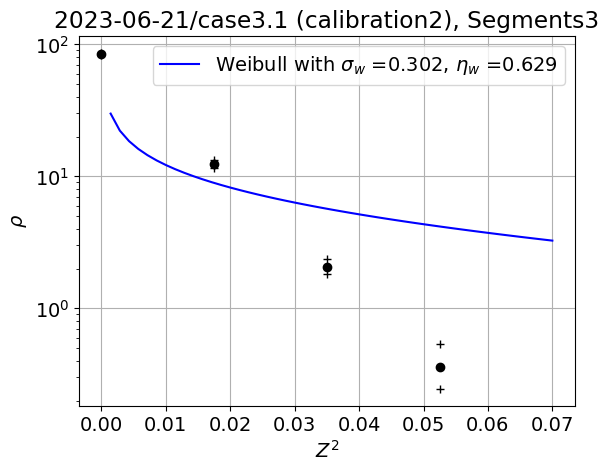

In [12]:
# Graph the probability
plt.figure()
fontsize = 14
plt.rcParams.update({'font.size': fontsize})
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder + ', ' + Segmentname)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b', \
             label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ', $\eta_w$ =' + str(etaW)[0:5])
plt.legend(fontsize=fontsize)

In [13]:
# # Save the roughness figure
# plt.savefig(Roughnessfilename)

In [14]:
# Saving ith segment as a textfile.
iSegment = 0
zfilename = Segmentname+'_z_values.csv'; print(zfilename)
xfilename = Segmentname+'_x_values.csv'; print(xfilename)
yfilename = Segmentname+'_y_values.csv'; print(yfilename)
Z2filename = Segmentname+'_Z2_values.csv'; print(Z2filename)
print(np.shape(zgridtot))
print(np.shape(Z2flat_list[iSegment]))

myxgridtot = xgridtot[iSegment,0,:]
myygridtot = ygridtot[iSegment,:,0]
myzgridtot = zgridtot[iSegment,:,:]
myZ2flat = Z2flat_list[iSegment]

nxy = np.shape(myzgridtot)
ny = nxy[0]
nx = nxy[1]
print(nxy)


myZ2 = np.reshape(myZ2flat, (ny-1,nx-1)) # Z2 is 1 shorter in either dimension


print(np.shape(myZ2))
np.savetxt(zfilename, myzgridtot, delimiter = ',')
np.savetxt(xfilename, myxgridtot, delimiter = ',')
np.savetxt(yfilename, myygridtot, delimiter = ',')
np.savetxt(Z2filename, Z2flat_list[iSegment], delimiter = ',')

fig = go.Figure(data = go.Surface(x = myxgridtot[1:], y = myygridtot[1:], z = myZ2))
fig.update_layout(scene = dict(xaxis_title = 'x',yaxis_title = 'y',zaxis_title = 'z'))

Segments3_z_values.csv
Segments3_x_values.csv
Segments3_y_values.csv
Segments3_Z2_values.csv
(1, 56, 51)
(2750,)
(56, 51)
(55, 50)
